In [20]:
path='C:\\jupyter\\Explainable Healthcare framework\\Explainable_healthcareframework\\'

In [21]:
# main.py
import pandas as pd
import torch
import numpy as np
# 로컬 모듈 임포트
from data_preparation import preprocess_data, convert_to_tensor
from encoding_tabnet import train_tabnet_classifier,create_augmented_features
from xgboost_optimizer import optimize_and_compare_models
from utils import standardize_features, calculate_metrics, save_model, print_results
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 프로젝트 루트 디렉토리 경로 (현재 파일의 상위 디렉토리)
Generation_list = ['smote','adasyn','copulagan','ctgan','nbsynthetic']

"""메인 함수"""
# 빈 리스트 생성하여 결과 저장
model_results_list = []

# Generation_list는 외부에서 정의되어야 함
generation = 'nbsynthetic'


print(f"\n처리 중인 생성 모델: {generation}")

# 1. 데이터 전처리
X_train, y_train, X_valid, y_valid, X_test, y_test = preprocess_data(generation)

print("y_train",np.unique(y_train))
# 2. TabNet 모델 학습
tabnet_model = train_tabnet_classifier(X_train, y_train, X_valid, y_valid)



처리 중인 생성 모델: nbsynthetic
경로 확인 c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework
y_train [0 1 2]
자동 계산된 클래스 가중치: [1.92284352 0.52057396 1.78897199]


c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.24927 | val_0_accuracy: 0.31767 |  0:00:08s
epoch 1  | loss: 0.49048 | val_0_accuracy: 0.18381 |  0:00:15s
epoch 2  | loss: 0.3931  | val_0_accuracy: 0.15216 |  0:00:23s
epoch 3  | loss: 0.34094 | val_0_accuracy: 0.17656 |  0:00:31s
epoch 4  | loss: 0.29493 | val_0_accuracy: 0.16485 |  0:00:39s
epoch 5  | loss: 0.27119 | val_0_accuracy: 0.18002 |  0:00:47s
epoch 6  | loss: 0.26192 | val_0_accuracy: 0.22239 |  0:00:55s
epoch 7  | loss: 0.24202 | val_0_accuracy: 0.29558 |  0:01:03s
epoch 8  | loss: 0.23304 | val_0_accuracy: 0.38592 |  0:01:11s
epoch 9  | loss: 0.22164 | val_0_accuracy: 0.4512  |  0:01:19s
epoch 10 | loss: 0.21258 | val_0_accuracy: 0.4761  |  0:01:27s
epoch 11 | loss: 0.21533 | val_0_accuracy: 0.46851 |  0:01:35s
epoch 12 | loss: 0.21345 | val_0_accuracy: 0.5821  |  0:01:44s
epoch 13 | loss: 0.21194 | val_0_accuracy: 0.64754 |  0:01:52s
epoch 14 | loss: 0.21239 | val_0_accuracy: 0.66897 |  0:02:00s
epoch 15 | loss: 0.19997 | val_0_accuracy: 0.72849 |  0

c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:

# 3. 모델 저장
model_save_path = path+f'\\3_1.Training_XAI_Proposed\\model_hist\\{generation}_proposed_tabnetEmbedd2.pickle'
save_model(tabnet_model, model_save_path)
tabnet_probs = tabnet_model.predict_proba(X_test)

# 5. TabNet 임베딩 추출
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_features = create_augmented_features(tabnet_model, X_train)
test_features = create_augmented_features(tabnet_model, X_test)


# 6. XGBoost 모델 최적화 및 학습
results, xgb_pred, best_xgb, xgb_probs = optimize_and_compare_models(
    train_features, 
    test_features, 
    y_train.astype(int), 
    y_test.astype(int), 
    n_trials=10,
    return_proba=True  # 확률값 반환하도록 수정
)

# 7. TabNet과 XGBoost 확률 합산   
print("tabnet_probs",tabnet_probs)
print("xgb_probs",xgb_probs)

# 확률 합산

combined_probs = (tabnet_probs + xgb_probs)

# # 가장 높은 확률을 가진 클래스 선택
ensemble_pred = np.argmax(combined_probs, axis=1)
# 8. 결과 출력
print_results(results)

[I 2025-05-19 18:12:45,939] A new study created in memory with name: no-name-6f21f54b-cb99-497e-a4d4-7908ae661d02
c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI

tabnet_probs [[1.2723508e-01 8.5466421e-01 1.8100657e-02]
 [9.3733676e-02 8.9170957e-01 1.4556725e-02]
 [2.8595515e-03 8.4002262e-01 1.5711784e-01]
 ...
 [9.9999475e-01 4.0309205e-06 1.1489764e-06]
 [9.9999952e-01 5.1222449e-10 4.2534882e-07]
 [9.9840945e-01 3.2476510e-05 1.5581293e-03]]
xgb_probs [[0.02629065 0.9390725  0.03463682]
 [0.0231694  0.9450416  0.03178895]
 [0.09665617 0.8540585  0.04928536]
 ...
 [0.83810824 0.0770259  0.08486587]
 [0.51181704 0.40825993 0.07992303]
 [0.537061   0.23186836 0.23107067]]

XGBoost Results:
Best Accuracy: 0.9066
Best Parameters:
  n_estimators: 134
  max_depth: 5
  learning_rate: 0.032471262278356006
  gamma: 9.732824710623538e-08
  min_child_weight: 6
  subsample: 0.694465098685676
  colsample_bytree: 0.6653872353643779
  reg_lambda: 5.682148498830337e-06
  reg_alpha: 0.15254205508392754


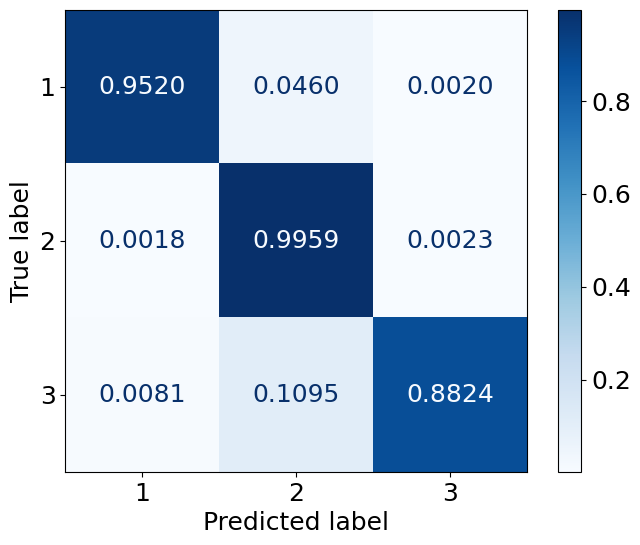


결과 요약:
                  Model  Accuracy  F1score  Precision   Recall
0  nbsynthetic-proposed   0.96769  0.96723    0.96843  0.96769
결과가 model_metrics.csv에 저장되었습니다.


In [23]:

# 9. XGBoost 모델 저장
xgb_save_path = path+f'\\3_1.Training_XAI_Proposed\\model_hist\\{generation}_proposed.pickle'
save_model(best_xgb, xgb_save_path)

# 10. 성능 지표 계산 (앙상블 예측 사용)
accuracy, f1, precision, recall = calculate_metrics(y_test, ensemble_pred)

# 11. 결과를 딕셔너리로 저장
result_dict = {
    'Model': f"{generation}-proposed",
    'Accuracy': round(accuracy, 5),
    'F1score': round(f1, 5),
    'Precision': round(precision, 5),
    'Recall': round(recall, 5)
}

# Confusion matrix 계산
cm = confusion_matrix(y_test, ensemble_pred, normalize='true')
class_labels = [1, 2, 3]

# 정확한 소수점 표시를 위한 함수
def format_cm(cm):
    # 각 행이 정확히 1.0이 되도록 정규화
    row_sums = cm.sum(axis=1, keepdims=True)
    normalized_cm = cm / row_sums
    
    return normalized_cm

# 행의 합이 정확히 1.0이 되도록 정규화
normalized_cm = format_cm(cm)
# Confusion matrix 시각화
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=normalized_cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.4f')  # 소수점 4자리까지 표시
# plt.title("Confusion Matrix", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# 값의 폰트 크기 조정
for text in disp.text_.ravel():
    text.set_fontsize(18)
plt.show()

# 12. 리스트에 딕셔너리 추가
model_results_list.append(result_dict)

# 13. 데이터프레임 생성
df_proposed = pd.DataFrame(model_results_list)
print("\n결과 요약:")
print(df_proposed)

# 14. 데이터프레임을 CSV 파일로 저장
output_path = 'model_metrics.csv'
df_proposed.to_csv(output_path)
print(f"결과가 {output_path}에 저장되었습니다.")


    

In [24]:
y_test

array([1, 1, 2, ..., 0, 0, 0], dtype=int64)

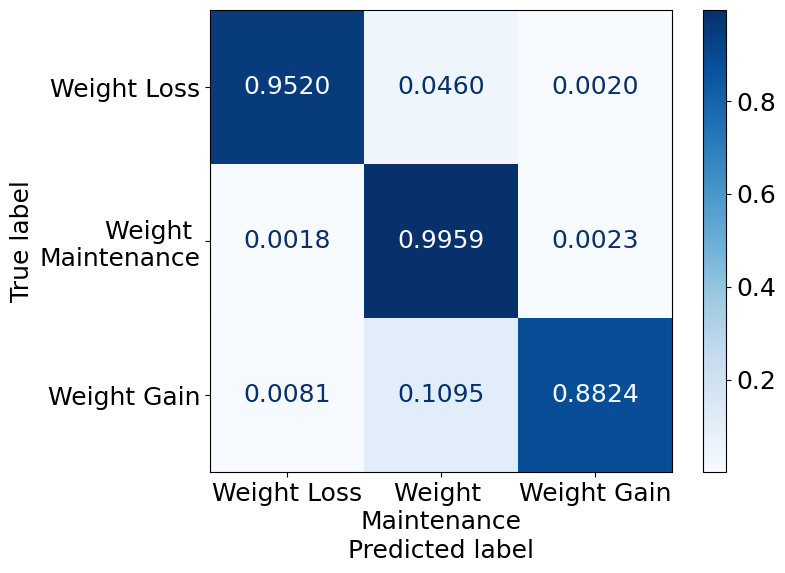

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 실제 값과 예측 값 (이전 코드에서 가져옴)
# test_targets_np = ...
# prediction = ...
class_labels = ['Weight Loss', 'Weight \nMaintenance', 'Weight Gain']

# 혼동 행렬 계산 및 정규화 (기존 format_cm 함수 활용)
cm = confusion_matrix(y_test, ensemble_pred, normalize=None) # normalize=None으로 변경
def format_cm(cm):
    row_sums = cm.sum(axis=1, keepdims=True)
    normalized_cm = cm / row_sums
    return normalized_cm

normalized_cm = format_cm(cm)

# 정규화된 혼동 행렬 값 올림 처리
normalized_cm_rounded = np.round(normalized_cm, 4)

# Confusion matrix 시각화 (올림 처리된 데이터 사용)
plt.rcParams.update({'font.size': 18})  # 폰트 크기 설정
fig, ax = plt.subplots(figsize=(8, 6))
disp_rounded = ConfusionMatrixDisplay(confusion_matrix=normalized_cm_rounded, display_labels=class_labels)
disp_rounded.plot(cmap=plt.cm.Blues, ax=ax, values_format='.4f')
plt.show()

## 데이터 생성 되지 않았을 때

In [26]:
## 데이터 생성 되지 않았을 때

In [38]:
path='C:\\jupyter\\Explainable Healthcare framework\\Explainable_healthcareframework'

In [39]:
seoul_data=pd.read_csv(path+"\\data\\5.서울초_df_final.csv",encoding="cp949")

In [40]:
os.chdir("..")
path=os.getcwd()

In [41]:
from Datapreprocessing.id_labelencoding import LabelEncoderWrapper 

df_encoder = LabelEncoderWrapper(seoul_data, 'ID')
df_encoder.fit()
df_encoder.transform()

In [42]:
from Datapreprocessing.M_day_N_term import RollingAveragesCalculator
M_day=14
n_term=1
columns_to_average = ["ID",'height', 'weight', 'step count', 'burned calorie', 'eat calorie', 'sleep time']
calculator = RollingAveragesCalculator(seoul_data)
result_df = calculator.calculate_averages(columns_to_average, M_day, n_term)

In [43]:
from Datapreprocessing.labeling import WeightChangeLabeler

Threshhold=0.1 # 몸무게가 얼마나 차이나야 변했다고 정할 것 인지 정하는 임계값
labeler = WeightChangeLabeler(result_df, Threshhold)
labeled_df = labeler.label_weight_changes()
print(labeled_df)

        ID      height     weight    step count  burned calorie  eat calorie  \
0        0  136.246429  28.478571   2051.107143       41.604375  2324.526395   
1        0  136.295238  28.571429   2113.707143       41.604375  2329.058538   
2        0  136.344048  28.664286   2205.121429       41.604375  2339.296038   
3        0  136.392857  28.757143   2325.350000       41.604375  2343.763895   
4        0  136.441667  28.850000   2474.392857       41.604375  2342.462110   
...    ...         ...        ...           ...             ...          ...   
40893  241  156.900000  47.500000  20000.000000       33.915000  1056.000000   
40894  241  156.900000  47.500000  20000.000000       33.915000  1056.000000   
40895  241  156.900000  47.500000  20000.000000       33.915000  1056.000000   
40896  241  156.900000  47.500000  20000.000000       33.915000  1056.000000   
40897  241  156.900000  47.500000  20000.000000       33.915000  1056.000000   

       sleep time  Start_Day Label  
0 

In [44]:
labeled_df['Label']=labeled_df['Label'].astype(int)

In [45]:
labeled_df['Label'].value_counts()

Label
2    39059
3     1300
1      539
Name: count, dtype: int64

In [46]:
data=labeled_df.iloc[:,[1,2,3,4,5,6,-1]]
train=data.iloc[:,:-1]
train_targets=data.iloc[:,-1]-1

In [47]:
np.random.seed(42)
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train","valid","test"], p =[.8, .1,.1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index
feature=train.iloc[:,:-1].columns
X_train = train[feature].values[train_indices]
y_train = train_targets.values[train_indices]

X_valid = train[feature].values[valid_indices]
y_valid = train_targets.values[valid_indices]

X_test = train[feature].values[test_indices]
y_test = train_targets.values[test_indices]

In [ ]:

print("y_train",np.unique(y_train))
# 2. TabNet 모델 학습
tabnet_model = train_tabnet_classifier(X_train, y_train, X_valid, y_valid)

# 3. 모델 저장
model_save_path = path+f'\\3_1.Training_XAI_Proposed\\model_hist\\proposed_tabnetEmbedd2_imbalanced.pickle'
# save_model(tabnet_model, model_save_path)
tabnet_probs = tabnet_model.predict_proba(X_test)

# 4. TabNet 확률 예측

# 5. TabNet 임베딩 추출
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_features = create_augmented_features(tabnet_model, X_train)
test_features = create_augmented_features(tabnet_model, X_test)


# 6. XGBoost 모델 최적화 및 학습
results, xgb_pred, best_xgb, xgb_probs = optimize_and_compare_models(
    train_features, 
    test_features, 
    y_train.astype(int), 
    y_test.astype(int), 
    n_trials=10,
    return_proba=True  # 확률값 반환하도록 수정
)

# 7. TabNet과 XGBoost 확률 합산   
print("tabnet_probs",tabnet_probs)
print("xgb_probs",xgb_probs)

# 확률 합산
combined_probs = (tabnet_probs + xgb_probs)

# # 가장 높은 확률을 가진 클래스 선택
ensemble_pred = np.argmax(combined_probs, axis=1)
# 8. 결과 출력
print_results(results)

# 9. XGBoost 모델 저장
xgb_save_path = path+f'\\3_1.Training_XAI_Proposed\\model_hist\\proposed_imbalanced.pickle'
# save_model(best_xgb, xgb_save_path)


y_train [0 1 2]
자동 계산된 클래스 가중치: [25.39302326  0.34910637 10.39904762]


c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.57245 | val_0_accuracy: 0.79674 |  0:00:08s
epoch 1  | loss: 1.06737 | val_0_accuracy: 0.46571 |  0:00:17s
epoch 2  | loss: 0.96248 | val_0_accuracy: 0.44771 |  0:00:25s
epoch 3  | loss: 0.91286 | val_0_accuracy: 0.84238 |  0:00:34s
epoch 4  | loss: 0.89586 | val_0_accuracy: 0.93858 |  0:00:42s
epoch 5  | loss: 0.88959 | val_0_accuracy: 0.94795 |  0:00:50s
epoch 6  | loss: 0.84086 | val_0_accuracy: 0.95042 |  0:00:58s
epoch 7  | loss: 0.80063 | val_0_accuracy: 0.92008 |  0:01:07s
epoch 8  | loss: 0.78125 | val_0_accuracy: 0.7447  |  0:01:15s
epoch 9  | loss: 0.76834 | val_0_accuracy: 0.73631 |  0:01:23s
epoch 10 | loss: 0.75112 | val_0_accuracy: 0.90528 |  0:01:32s
epoch 11 | loss: 0.75978 | val_0_accuracy: 0.815   |  0:01:40s
epoch 12 | loss: 0.7517  | val_0_accuracy: 0.87889 |  0:01:49s
epoch 13 | loss: 0.75365 | val_0_accuracy: 0.91391 |  0:01:57s
epoch 14 | loss: 0.72487 | val_0_accuracy: 0.69388 |  0:02:05s
epoch 15 | loss: 0.68504 | val_0_accuracy: 0.60064 |  0

c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-19 19:30:33,947] A new study created in memory with name: no-name-e67130b8-f7ef-428b-8b4d-ef3f64d8ce40
c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugges

tabnet_probs [[1.8018942e-19 1.0000000e+00 2.1881861e-16]
 [1.6756519e-20 1.0000000e+00 4.4084508e-17]
 [1.2386131e-24 1.0000000e+00 2.3569621e-20]
 ...
 [4.8475461e-29 1.0000000e+00 2.3678562e-21]
 [4.8475461e-29 1.0000000e+00 2.3678562e-21]
 [4.8475461e-29 1.0000000e+00 2.3678562e-21]]
xgb_probs [[0.00640253 0.9790549  0.01454256]
 [0.01695659 0.9115106  0.0715329 ]
 [0.01244652 0.962513   0.02504044]
 ...
 [0.00253909 0.9906743  0.00678665]
 [0.00253909 0.9906743  0.00678665]
 [0.00253909 0.9906743  0.00678665]]

XGBoost Results:
Best Accuracy: 0.9574
Best Parameters:
  n_estimators: 136
  max_depth: 4
  learning_rate: 0.10018325597861442
  gamma: 0.23239648912897665
  min_child_weight: 5
  subsample: 0.8418284412902128
  colsample_bytree: 0.7534695623088546
  reg_lambda: 0.0003049194004115791
  reg_alpha: 0.02966958701536781


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\jupyter\\3_1.Training_XAI_Proposed\\model_hist\\proposed_imbalanced.pickle'

c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


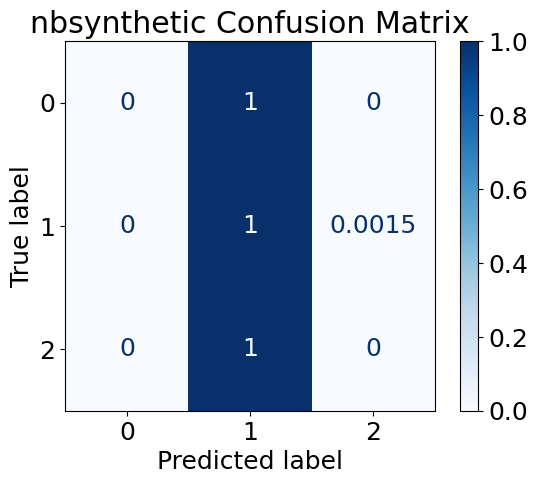

In [51]:

# 10. 성능 지표 계산 (앙상블 예측 사용)
accuracy, f1, precision, recall = calculate_metrics(y_test, ensemble_pred)

# 11. 결과를 딕셔너리로 저장
result_dict = {
    'Model': f"{generation}-proposed",
    'Accuracy': round(accuracy, 5),
    'F1score': round(f1, 5),
    'Precision': round(precision, 5),
    'Recall': round(recall, 5)
}

# Confusion matrix 계산
cm = confusion_matrix(y_test, ensemble_pred, normalize='true')
# Confusion matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"{generation} Confusion Matrix")
plt.show()
# 12. 리스트에 딕셔너리 추가
model_results_list.append(result_dict)

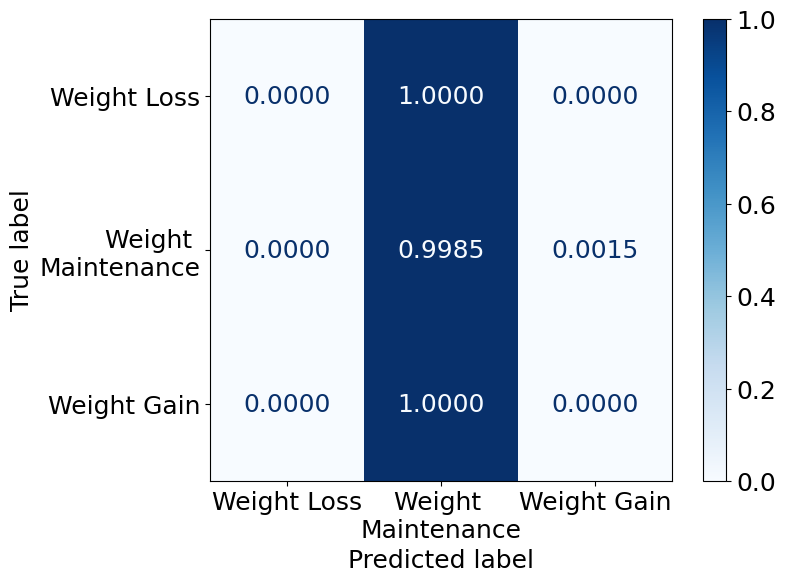

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 실제 값과 예측 값 (이전 코드에서 가져옴)
# test_targets_np = ...
# prediction = ...
class_labels = ['Weight Loss', 'Weight \nMaintenance', 'Weight Gain']

# 혼동 행렬 계산 및 정규화 (기존 format_cm 함수 활용)
cm = confusion_matrix(y_test, ensemble_pred, normalize=None) # normalize=None으로 변경
def format_cm(cm):
    row_sums = cm.sum(axis=1, keepdims=True)
    normalized_cm = cm / row_sums
    return normalized_cm

normalized_cm = format_cm(cm)

# 정규화된 혼동 행렬 값 올림 처리
normalized_cm_rounded = np.round(normalized_cm, 4)

# Confusion matrix 시각화 (올림 처리된 데이터 사용)
plt.rcParams.update({'font.size': 18})  # 폰트 크기 설정
fig, ax = plt.subplots(figsize=(8, 6))
disp_rounded = ConfusionMatrixDisplay(confusion_matrix=normalized_cm_rounded, display_labels=class_labels)
disp_rounded.plot(cmap=plt.cm.Blues, ax=ax, values_format='.4f')
plt.show()